In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Este proyecto toma una base de datos con información sobre diversas condiciones climáticas.
Se utilizará un modelo de redes neuronales LSTM, para predecir la temperatura futura a lo largo del tiempo durante todo el año 2014.



###La base de datos fue extraida del siguiente enlace: https://www.kaggle.com/datasets/stytch16/jena-climate-2009-2016/data

Nombre: Sebastián Rodríguez López

In [3]:
#lectura de datos
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Modulo-6-dccd/jena_climate_2009_2016.csv", encoding='latin-1')

# Convertir la columna 'Date Time' a datetime
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

print("Rango de fechas en el dataset:")
print(df['Date Time'].min(), "a", df['Date Time'].max())


Rango de fechas en el dataset:
2009-01-01 00:10:00 a 2017-01-01 00:00:00


In [4]:
#filtramos para el año 2014 para reducir la cantidad de datos y establecer predicciones en un año en específico
df_2014 = df[df['Date Time'].dt.year == 2014]


In [ ]:
#convertimos y guardamos el nuevo dataframe
df_2014.to_csv('/content/drive/MyDrive/Colab Notebooks/Modulo-6-dccd/jena_climate_2014.csv', index=False)

In [5]:
train_data= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Modulo-6-dccd/jena_climate_2014.csv')
train_data= df_2014.sample(frac=0.15, random_state=42)

Nuestro target es predecir la temperatura futura, usando como variables la presion atmosferica p(mbar), temperatura potencial en kelvin Tpot(K), la humedad relativa rh (%), presion de vapor actual VPact (mbar), velocidad del viento wv (m/s) y velocidad maxima del viento max. wv (m/s)

In [6]:
train_data_n= train_data[['T (degC)','p (mbar)','Tpot (K)', 'rh (%)',
    'VPact (mbar)', 'wv (m/s)', 'max. wv (m/s)']]

Normalizamos los datos usando MinMaxScaler para una mejor efiencia a la hora de procesar los datos.

Se crean secuencias de datos de 60 días, hecho esto, el modelo se entrena con estas secuencias para predecir la temperatura en función de las variables mencionadas anteriormente. Este modelo tiene dos capas LSTM y una capa densa final.

In [7]:
#escalando datos
scaler= MinMaxScaler(feature_range=(0,1)) #transforma los datos en ceros y uno
train_scaled=scaler.fit_transform(train_data_n)

#Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=60):
  X, Y= [], []
  for i in range(len(dataset)-look_back):
    a=dataset[i:(i+look_back), :]
    X.append(a)
    Y.append(dataset[i+look_back, 0])
  return np.array(X), np.array(Y)

X_train, y_train= create_dataset(train_scaled, 60)

#Modelo LSTM
model= Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True), #return_sequences= True devuelve las salidas
    Dropout(0.2), #evita el sobreajuste, apaga aleatoriamente el 20% de las neuronas durante el entrenamiento
    LSTM(100, return_sequences=False), #return_sequences= false nos da la salida final y no toda la secuencia
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,701 (483.21 KB)

 Trainable params: 123,701 (483.21 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0368
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0288
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0297
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0290
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0286
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0288
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0287
Epoch 8/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0282
Epoch 9/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0287
Epoch 10/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0283
Epoch 11/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0283
Epoch 12/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0283
Epoch 13/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0284
Epoch 14/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0288
Epoch 15/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/s

In [10]:
# Preparar los datos reales de 2024 para comparación
real_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Modulo-6-dccd/jena_climate_2014.csv', index_col='Date Time', parse_dates=True)

real_data= real_data[['T (degC)','p (mbar)','Tpot (K)', 'rh (%)',
    'VPact (mbar)', 'wv (m/s)', 'max. wv (m/s)']]
real_scaled = scaler.transform(real_data)

In [11]:
# Crear datos de entrada para predicción
X_real, _ = create_dataset(np.vstack([train_scaled[-60:], real_scaled]), 60)

# Predicciones
predictions_scaled = model.predict(X_real)

#Ajustar las predicciones al shape original antes de la transformación inversa
predictions_scaled_reshaped = np.zeros((len(predictions_scaled), train_scaled.shape[1])) # Crea un array con la forma original
predictions_scaled_reshaped[:,0] = predictions_scaled[:,0] # Coloca las predicciones en la primera columna

predictions = scaler.inverse_transform(predictions_scaled_reshaped)[:, 0] #inversa la transformación

# Datos reales para comparar
real_demand = scaler.inverse_transform(real_scaled)[:, 0]

1646/1646 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


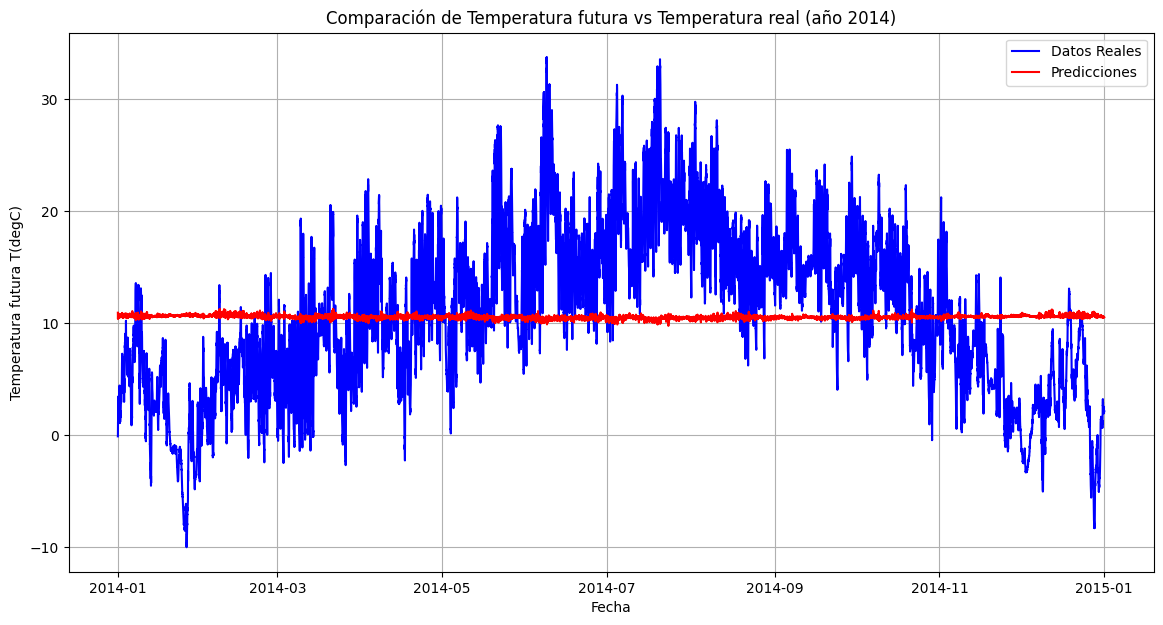

In [12]:
# Graficar
plt.figure(figsize=(14, 7))
plt.plot(real_data.index, real_demand, label='Datos Reales', color='blue')
plt.plot(real_data.index[:len(predictions)], predictions, label='Predicciones', color='red')
plt.title('Comparación de Temperatura futura vs Temperatura real (año 2014)')
plt.xlabel('Fecha')
plt.ylabel('Temperatura futura T(degC)')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
import plotly.graph_objects as go
import pandas as pd
from sklearn.metrics import r2_score

# Asegurarse de que tanto 'real_demand' como 'predictions' tienen el mismo índice de tiempo
real_demand = pd.Series(real_demand[:len(predictions)], index=real_data.index[:len(predictions)])
predictions_series = pd.Series(predictions, index=real_data.index[:len(predictions)])

# Crear una lista para almacenar los R-squared de cada mes
r_squared_monthly = []

# Agrupar los datos por mes y calcular el R-squared para cada mes
for month, group in real_demand.groupby(real_demand.index.month):
    # Extraer las predicciones correspondientes para ese mes
    pred_for_month = predictions_series[group.index]

    # Asegurarse de que 'group' y 'pred_for_month' tengan la misma longitud
    min_len = min(len(group), len(pred_for_month))
    group = group[:min_len]
    pred_for_month = pred_for_month[:min_len]

    # Calcular el R-squared
    r_squared = r2_score(group, pred_for_month)

    # Almacenar el resultado
    r_squared_monthly.append((month, r_squared))
    print(f'R-squared para el mes {month}: {r_squared}')

# Crear la figura usando Plotly para una mejor interactividad y presentación
fig = go.Figure()

# Añadir los datos reales a la gráfica
fig.add_trace(go.Scatter(x=real_data.index, y=real_demand, mode='lines', name='Datos Reales', line=dict(color='blue')))

# Añadir las predicciones a la gráfica
fig.add_trace(go.Scatter(x=real_data.index[:len(predictions)], y=predictions, mode='lines', name='Predicciones', line=dict(color='red')))

# Configuración adicional del gráfico
fig.update_layout(
    title='Comparación de Temperatura futura vs Temperatura real (año 2014)',
    xaxis_title='Fecha',
    yaxis_title='Temperatura futura T(degC)',
    legend_title='Leyenda'
)

# Mostrar la gráfica
fig.show()

# Imprimir los R-squared mensuales
for month, r_squared in r_squared_monthly:
    print(f"R-squared para el mes {month}: {r_squared:.4f}")

R-squared para el mes 1: -3.286448906604801
R-squared para el mes 2: -3.1269722386796905
R-squared para el mes 3: -0.31527819618782993
R-squared para el mes 4: -0.05631161862643008
R-squared para el mes 5: -0.2263156905354562
R-squared para el mes 6: -1.5036938394916444
R-squared para el mes 7: -4.2439386391406
R-squared para el mes 8: -1.9479826581982422
R-squared para el mes 9: -1.773120684980383
R-squared para el mes 10: -0.1705005547788756
R-squared para el mes 11: -1.2521660035033237
R-squared para el mes 12: -3.497398667699634


R-squared para el mes 1: -3.2864
R-squared para el mes 2: -3.1270
R-squared para el mes 3: -0.3153
R-squared para el mes 4: -0.0563
R-squared para el mes 5: -0.2263
R-squared para el mes 6: -1.5037
R-squared para el mes 7: -4.2439
R-squared para el mes 8: -1.9480
R-squared para el mes 9: -1.7731
R-squared para el mes 10: -0.1705
R-squared para el mes 11: -1.2522
R-squared para el mes 12: -3.4974
